In [1]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00


In [2]:
!pip install -q pytorch-lightning wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.6/188.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.8/218.8 kB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [3]:
# Importing the necessary libraries and modules

from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
import pytorch_lightning as pl
from tqdm import tnrange
from collections import Counter
from sklearn.model_selection import train_test_split

# from evaluate import load
# import bert_score
from transformers import logging
logging.set_verbosity_error()
import matplotlib.pyplot as plt

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
# load the dataset

dataset = load_dataset("Owishiboo/grammar-correction", split="train")
print(dataset)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['Unnamed: 0', 'input', 'target'],
    num_rows: 6004
})


In [5]:
# Separation of the dataset into training, validation and test sets

train_testvalid = dataset.train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'input', 'target'],
        num_rows: 4803
    })
    test: Dataset({
        features: ['Unnamed: 0', 'input', 'target'],
        num_rows: 601
    })
    valid: Dataset({
        features: ['Unnamed: 0', 'input', 'target'],
        num_rows: 600
    })
})

In [6]:
# Displaying a sample data example

example = dataset['train'][0]

print("input:", example["input"])
print("target:", example["target"])

input:  He knows many countries around the world .
target: He knows many countries around the world .


In [7]:
# Tokenizer Configuration and Preprocessing Function

tokenizer = AutoTokenizer.from_pretrained("t5-small")

prefix = "correction: "
max_input_length = 600
max_target_length = 600

def preprocessor(examples, prefix='correction:', max_input_length=512, max_target_length=512):
  sentences = examples['input']
  corrections = examples['target']

  # encode the input sentences
  inputs = [prefix + sentence for sentence in sentences]
  model_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True)

  # encode the target sentences and extract input_ids
  labels = tokenizer(corrections, max_length=max_target_length, padding="max_length", truncation=True).input_ids

  # Replace the index of the padding tokens by -100
  # such that they are not taken into account by the CrossEntropyLoss
  labels_with_ignore_index = []
  for labels_example in labels:
    labels_example = [label if label != 0 else -100 for label in labels_example]
    labels_with_ignore_index.append(labels_example)

  model_inputs["labels"] = labels_with_ignore_index

  return model_inputs

In [8]:
# Dataset Mapping

# Apply the preprocessing function to the entire dataset in batches
dataset = dataset.map(preprocessor, batched=True)
print(dataset)


Map:   0%|          | 0/4803 [00:00<?, ? examples/s]

Map:   0%|          | 0/601 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'input', 'target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4803
    })
    test: Dataset({
        features: ['Unnamed: 0', 'input', 'target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 601
    })
    valid: Dataset({
        features: ['Unnamed: 0', 'input', 'target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 600
    })
})


In [9]:
# Dataset Formatting

# Set the dataset format to "torch"
dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'input', 'target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4803
    })
    test: Dataset({
        features: ['Unnamed: 0', 'input', 'target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 601
    })
    valid: Dataset({
        features: ['Unnamed: 0', 'input', 'target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 600
    })
})


In [10]:
# Data Loaders Configuration

# Determine the number of CPU cores available.
num_workers = os.cpu_count()

# Create data loaders for training, validation, and testing datasets.
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=8, num_workers=num_workers)
valid_dataloader = DataLoader(dataset['valid'], batch_size=4, num_workers=num_workers)
test_dataloader = DataLoader(dataset['test'], batch_size=4, num_workers=num_workers)


In [11]:
# Fetch a batch from the training data loader

batch = next(iter(train_dataloader))
print(batch.keys())


dict_keys(['input_ids', 'attention_mask', 'labels'])


In [12]:
# Decode the input_ids of the first example in the batch.
tokenizer.decode(batch['input_ids'][0])

'correction: There are more population in every area.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [13]:
# Decode the labels of the first example in the batch, filtering out -100 tokens
labels = batch['labels'][0]
tokenizer.decode([label for label in labels if label != -100])

'There is a greater population in every area.</s>'

In [14]:
class T5(pl.LightningModule):
    def __init__(self, lr=5e-5, num_train_epochs=15, warmup_steps=1000):
        # Initializes the T5 model and sets up training-related attributes
        super().__init__()
        self.model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
        self.train_losses=[]
        self.validation_losses=[]
        self.config=self.model.config

        self.train_losses_epoch=[]
        self.validation_losses_epoch=[]

        self.save_hyperparameters()


    def forward(self, input_ids, attention_mask, labels=None):
        # Performs a forward pass through the T5 model
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return outputs


    def common_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs.loss
        return loss


    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.train_losses.append(loss)
        return loss


    def validation_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True)
        self.validation_losses.append(loss)
        return loss


    def on_train_epoch_end(self):
        # Calculate average loss for the epoch and append to the list
        avg_train_loss = sum(self.train_losses)/ len(self.train_losses)
        self.train_losses_epoch.append(avg_train_loss.item())

        # Reset epoch loss accumulator
        self.train_losses = []


    def on_validation_epoch_end(self):
        # Calculate average loss for the epoch and append to the list
        avg_val_loss = sum(self.validation_losses) / len(self.validation_losses)
        self.validation_losses_epoch.append(avg_val_loss.item())

        # Reset epoch loss accumulator
        self.validation_losses = []

        # Reset epoch loss accumulator
        self.test_losses = []


    def configure_optimizers(self):
        # create optimizer
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        # create learning rate scheduler
        num_train_optimization_steps = self.hparams.num_train_epochs * len(train_dataloader)
        lr_scheduler = {'scheduler': get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=self.hparams.warmup_steps,
                                                    num_training_steps=num_train_optimization_steps),
                        'name': 'learning_rate',
                        'interval':'step',
                        'frequency': 1}

        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}


    def generate(self, input_ids, max_new_tokens=100, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        input_ids=input_ids.clone().detach().reshape((1,-1)).to(device)
        return self.model.generate(input_ids, max_new_tokens=max_new_tokens)


    def push_to_hub(self, model_name, organization):
        # Save the model
        self.model.push_to_hub(model_name, organization)


    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return valid_dataloader

    def test_dataloader(self):
        return test_dataloader

In [15]:
# Hyperparameters
lr = 5e-5
num_train_epochs = 10
warmup_steps = 1000
patience = 2
max_epochs = 10

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
# Early stopping callback - Stops training if validation loss doesn't improve for 'patience' epochs
early_stop_callback = EarlyStopping(
    monitor='validation_loss',
    patience=patience,
    strict=False,
    verbose=False,
    mode='min'
)
lr_monitor = LearningRateMonitor(logging_interval='step')
# Model checkpoint callback - Saves the best model during training based on validation loss
checkpoint_callback = ModelCheckpoint(dirpath='./', monitor='validation_loss', mode='min', save_top_k = 1)

accelerator = "gpu" if torch.cuda.is_available() else "cpu"
# Create a PyTorch Lightning Trainer instance with defined callbacks and max_epochs
trainer = Trainer(accelerator=accelerator,
                  callbacks=[early_stop_callback, lr_monitor, checkpoint_callback], max_epochs=max_epochs)

# Create an instance of our T5 model with specified hyperparameters
model = T5(lr=lr, num_train_epochs=num_train_epochs, warmup_steps=warmup_steps)
# Train the model
trainer.fit(model)
tokenizer.save_pretrained("./")
checkpoint_path = checkpoint_callback.best_model_path

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [16]:
# Retrieve the training and validation losses of the model

train_losses=model.train_losses_epoch
validation_losses=model.validation_losses_epoch


In [17]:
print('Loss on validation set before fine tuning: ', validation_losses[0])

Loss on validation set before fine tuning:  1.25543212890625


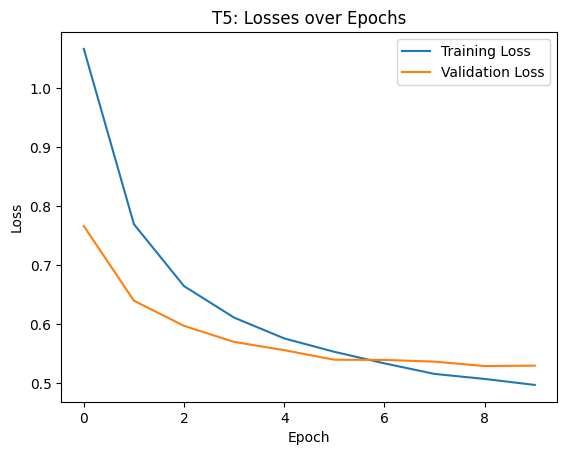

In [18]:
# Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses[1:], label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('T5: Losses over Epochs')

# Adding legend
plt.legend()

plt.savefig('losses_plot.png')
# Displaying the plot
plt.show()

In [19]:
data_id = 9
test_dataset = dataset['test']
test_input = test_dataset['input'][data_id]
test_input_ids = test_dataset[data_id]['input_ids']
test_target = test_dataset['target'][data_id]
test_attention_mask = test_dataset[data_id]['attention_mask']

In [20]:
# Checking if a GPU is available, and setting the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Moving the model to the selected device (GPU or CPU)
model = model.to(device)


In [21]:
print("Input sentence:")
print(test_input)

Input sentence:
 It may tell us how large the world it is .


In [22]:
print("target:")
print(test_target)

target:
It may tell us how large the world is .


In [23]:
# Generating corrected text using the fine-tuned T5 model
output_ids = model.generate(test_input_ids.reshape((1,-1)))

# Decoding the generated output and removing special tokens
corrected_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)


In [24]:
print("Corrected sentence:")
print(corrected_sentence)

Corrected sentence:
It may tell us how large the world is.
